## Cell 1:

In [2]:
#Cell 1
##########
# 27 September 2021
# K. M. Jones (kmj.jones@gmail.com)
#This quick notebook takes in fully processed, registered, trimmed, and re-convolved astronomical images
#and runs them through Source Extractor's dual image mode
#using settings that were selected to best handle the data from GoGreen clusters of galaxies (described, and set, in default_dualimage.sex)
#and produces an output Fits file holding a combined table of data from both the red and blue images
#identified using the positions determined from the redder of the two images

#It then adds two columns containing information from the weight images associated with
#both the red and the blue (reprojected) image (the reprojected blue weight image)
# hmmm shoot do I need to convolve that blue weight image too?? 

#next, it adds two columns of information that give the noise dispersion for the 
#flux_aper measurements made in red and blue

## Cell 2:

In [ ]:
#Cell 2
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import getweight
from astropy import wcs
import depthcalc
import scipy as sp
import math as m


## Cell 3:

In [8]:
#Cell 3
#update this to have user input filered, fileblue, and output catalog names
filered="../HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits"
fileblue="../HSTdata/j2106_blue2red_exact_conv_apr21_5.fits"

red_hdu=fits.open(filered)
blue_hdu=fits.open(fileblue)
rhdr=red_hdu[0].header
bhdr=blue_hdu[0].header
photvals=[rhdr['PHOTFLAM'],rhdr['PHOTPLAM']]
photvalsb=[bhdr['PHOTFLAM'],bhdr['PHOTPLAM']]

#will need an output objectsubtracted or seg image to calculate the rms?
#hmm, maybe to use the pre-dual-mode images to calc rms bc more accurate (more area, def) for ie blue

wb=os.system("sextractor" + " " + filered + "," + filered + " -c default_dualimage.sex")# -CATALOG_NAME j2106_dualrr_cbs_min5.cat -CHECKIMAGE_TYPE -OBJECTS -CHECKIMAGE_NAME j2106_dualrr_objsub_cbs_min5.fits")
wr=os.system("sextractor" + " " + filered + "," + fileblue + " -c default_dualimage.sex") # -CATALOG_NAME j2106_dualrb_cbs_min5.cat -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME j2106_dualrb_seg_cbs_min5.fits")

##  Cell 4:

In [9]:
#Cell 4
f=open('j2106_dualrr_cbs_min5.cat','r')
g=open('j2106_dualrb_cbs_min5.cat','r')
#typehold='f8,f8,f8,f8,i8,f8,f8,f8,f8,f8,f8,f8,f8,f8,i8,f8,f8,f8'
colnames=['SE_ID_f105w','X_IMAGE_f105w','Y_IMAGE_f105w','ALPHA_J2000_f105w','DELTA_J2000_f105w','SEFLAGS_f105w','CLASS_STAR_f105w','FLUX_AUTO_f105w','FLUXERR_AUTO_f105w','FLUX_ISO_f105w','FLUXERR_ISO_f105w','FLUX_APER_f105w','FLUXERR_APER_f105w','FWHM_IMAGE_f105w','KRON_RADIUS_f105w','ISOAREA_IMAGE_f105w','A_IMAGE_f105w','B_IMAGE_f105w','THETA_IMAGE_f105w']
colnames2=['X_IMAGE_f606w','Y_IMAGE_f606w','ALPHA_J2000_f606w','DELTA_J2000_f606w','SEFLAGS_f606w','CLASS_STAR_f606w','FLUX_AUTO_f606w','FLUXERR_AUTO_f606w','FLUX_ISO_f606w','FLUXERR_ISO_f606w','FLUX_APER_f606w','FLUXERR_APER_f606w','FWHM_IMAGE_f606w','KRON_RADIUS_f606w','ISOAREA_IMAGE_f606w','A_IMAGE_f606w','B_IMAGE_f606w','THETA_IMAGE_f606w']

datarr=np.genfromtxt(f,skip_header=19,comments='#',usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))

datarb=np.genfromtxt(g,skip_header=19,comments='#',usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))

#row-based arrangement
data_total=np.concatenate((datarr,datarb),axis=1)
nms=np.concatenate((colnames, colnames2),axis=0)



#print(nms)

#print(np.shape(datarr),np.shape(datarb),np.shape(data_total))
#print(datarr[0,13],datarr[0,14])
#print(datarb[0,12],datarb[0,13])
#print(data_total[6,13],data_total[6,14])
#print(data_total[6,30],data_total[6,31])

## Cell 5:

In [10]:
#Cell 5
##### convert units for catalog output
#make units: uJy (for catalog; convert to magnitude when USE catalog to make plot
# OR Give f/f(m=25) as the catalog quantity,
#such that you can compute AB magnitude using m = -2.5 * log(f/f(m=25)) + 25
#note that FLUXAPER and FLUXAUTO and etc that result from 
#source extractor should be in *counts*, so need to be converted to Jy first.

print('red auto iso aper:',np.where(nms=='FLUX_AUTO_f105w'),np.where(nms=='FLUX_ISO_f105w'),np.where(nms=='FLUX_APER_f105w'))
print('blue auto iso aper:',np.where(nms=='FLUX_AUTO_f606w'),np.where(nms=='FLUX_ISO_f606w'),np.where(nms=='FLUX_APER_f606w'))



photflam_red=photvals[0]
photflam_blue=photvalsb[0]
photplam_red=photvals[1]
photplam_blue=photvalsb[1]
c_ang=sp.constants.c * (10.0**10.0)
conversion=((photplam_red*photplam_red)/c_ang)*(1.0/(10.0**(-23.0)))*(10.0**6.0)
convb=((photplam_blue*photplam_blue)/c_ang)*(1.0/(10.0**(-23.0)))*(10.0**6.0)

countsauto_f105w=data_total[:,int(np.where(nms=='FLUX_AUTO_f105w')[0])] #from lines 8 and 9 in this cell
#cerr_auto_f105w=data_total[:,int(np.where(nms=='FLUXERR_AUTO_f105w')[0])]
countsiso_f105w=data_total[:,int(np.where(nms=='FLUX_ISO_f105w')[0])]
#cerr_iso_f105w=data_total[:,int(np.where(nms=='FLUXERR_ISO_f105w')[0])]
countsaper_f105w=data_total[:,int(np.where(nms=='FLUX_APER_f105w')[0])]
#cerr_aper_f105w=data_total[:,int(np.where(nms=='FLUXERR_APER_f105w')[0])]
countsauto_f606w=data_total[:,int(np.where(nms=='FLUX_AUTO_f606w')[0])]
#cerr_auto_f606w=data_total[:,int(np.where(nms=='FLUXERR_AUTO_f606w')[0])]
countsiso_f606w=data_total[:,int(np.where(nms=='FLUX_ISO_f606w')[0])]
#cerr_iso_f606w=data_total[:,int(np.where(nms=='FLUXERR_ISO_f606w')[0])]
countsaper_f606w=data_total[:,int(np.where(nms=='FLUX_APER_f606w')[0])]
#cerr_aper_f606w=data_total[:,int(np.where(nms=='FLUXERR_APER_f606w')[0])]

#recall f_nu= pivot lambda^2/c * flambda?
flambda_auto_f105w=countsauto_f105w*photflam_red
fnu_auto_f105w = flambda_auto_f105w*conversion #now in microJansky
flambda_iso_f105w=countsiso_f105w*photflam_red
fnu_iso_f105w = flambda_iso_f105w*conversion #now in microJansky
flambda_aper_f105w=countsaper_f105w*photflam_red
fnu_aper_f105w = flambda_aper_f105w*conversion #now in microJansky
flam_auto_606=countsauto_f606w*photflam_blue
fnu_auto_f606w=flam_auto_606*convb #now in microJansky
flam_iso_f606w=countsiso_f606w*photflam_blue
fnu_iso_f606w=flam_iso_f606w*convb
flam_aper_f606w=countsaper_f606w*photflam_blue
fnu_aper_f606w=flam_aper_f606w*convb



red auto iso aper: (array([7]),) (array([9]),) (array([11]),)
blue auto iso aper: (array([25]),) (array([27]),) (array([29]),)


## Cell 6:

In [11]:
#Cell 6

##Pull the weight value from the corresponding(ish) pixel for each band's wht.fits


#oh, crap, x_image and y_image aren't integers -.-
#round them to the nearest integer and then subtract 1 from each to feed 
#into the array that wi gives (a regular ol array starts at 0,0)
redwht="../HSTdata/j210604m5845/j210604m5845-f105w_drz_wht.fits"
bluewht="../HSTdata/j2106_blue2red_exactfinal_wht.fits"
#above is the weight image, reprojected (blue2red_exactfinal)
#uhhhhhhh should I convolve it too? IDK why, that should only concern the spread of flux, not weight
#bluewht="../HSTdata/j210604m5845/j210604m5845-f606w_drc_wht.fits"

wi_f105w=[]
wi_f606w=[]


for i in range(len(data_total[:,1])):
    wix=round(data_total[i,1])
    wiy=round(data_total[i,2])
    wir=getweight.wi(redwht,wix,wiy)
    wi_f105w.append(wir)
    wib=getweight.wi(bluewht,wix,wiy)
    wi_f606w.append(wib)

wr10pct,wrmax=getweight.getmax(redwht)
wb10pct,wbmax=getweight.getmax(bluewht)
print(wr10pct,wb10pct)
#output these to meta-table? or just use em myself

#add wi columns
wif105w=np.array(wi_f105w)
wir_wimx=wif105w/wr10pct
wi_red=wir_wimx.reshape((1740,1))
wif606w=np.array(wi_f606w)
wib_wimx=wif606w/wb10pct
wi_blue=wib_wimx.reshape((1740,1))


#####a little check demonstrating why we want wb10pct instead of wbmax
####don't need to run this
#wr10pct,wrmax=getweight.getmax(redwht)
#wb10pct,wbmax=getweight.getmax(bluewht)
#print('10percent from the top red, highestred, then same for blue,blue',wr10pct,wrmax)
#print(wb10pct,wbmax)
#plt.plot(wif606w,'g.') shows why we want wb10pct instead of wbmax



10694.942 29770.775825471697


## Cell 7:

In [12]:
#Cell 7
### make/calculate/construct new errrors for flux auto1 and flux auto2
#disp_i(N) = N*o_bar(a_i + (b_i * N))/np.sqrt(wi)
#need: N, linear size = sqrt(area) ~radius. aperture is 5.0 pixels diameter so 2.5 pix radius
#o_bar (rms for the image/band),
#ai and bi (coefficients of the parameterized function for the image/band)
#weight value (wi, not wi/wimax)
denomr=np.sqrt(wif105w)
denomb=np.sqrt(wif606w)


kr_red = data_total[:,int(np.where(nms=='KRON_RADIUS_f105w')[0])]#this isn't radius yet
a_red=data_total[:,int(np.where(nms=='A_IMAGE_f105w')[0])]
b_red=data_total[:,int(np.where(nms=='B_IMAGE_f105w')[0])]
N_AUTOred=np.sqrt(m.pi*(a_red*kr_red)*(b_red*kr_red))
kr_blue = data_total[:,int(np.where(nms=='KRON_RADIUS_f606w')[0])]
a_blue=data_total[:,int(np.where(nms=='A_IMAGE_f606w')[0])]
b_blue=data_total[:,int(np.where(nms=='B_IMAGE_f606w')[0])]
N_AUTOblue= np.sqrt(m.pi*(a_blue*kr_blue)*(b_blue*kr_blue))

Naper = 2.5  #aperture is 5.0 pixels diameter so 2.5 pix radius . NOTE THIS IS N_APER; same for red and blue
N_ISO1red = data_total[:,int(np.where(nms=='ISOAREA_IMAGE_f105w')[0])] #this should = sqrt of ISO_AREA
N_ISO_f105w=np.sqrt(N_ISO1red)
N_ISO1blue = data_total[:,int(np.where(nms=='ISOAREA_IMAGE_f606w')[0])]
N_ISO_f606w=np.sqrt(N_ISO1blue)

#well, I should read this out of the meta-table that I haven't created yet
#specific to individual bands and clusters (each image)
#C1 and C2 come from fitting in Working_Depth.ipynb
fileredmask='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci_mask.fits'
fileredseg='/home/k689j329/HSTdata/j210604m5845/j210604m5845_f105w_seg_newnorm3.fits'
obar_counts_f105w,useless=depthcalc.rmscalc(filered,fileredmask,fileredseg,[5,10]) #(note that these are just some random values in the array bc it requires it to be input to make the second output; but we don't care about the second output so basically ignore. later on I should set it up to be default turned off or something)
obar_f105w=obar_counts_f105w*photflam_red*conversion
C1_f105w=0.01652168137
a_f105w=C1_f105w/obar_f105w
C2_f105w=0.002475885999
b_f105w=C2_f105w/obar_f105w

filebluemask='/home/k689j329/HSTdata/j2106_blue2red_exact_conv_apr21_5_mask.fits'
fileblueseg='/home/k689j329/sextractor-2.19.5/j2106_b2rec_apr21_5_seg.fits'
obar_counts_f606w,useless=depthcalc.rmscalc(fileblue,filebluemask,fileblueseg,[5,10])
obar_f606w=obar_counts_f606w*photflam_blue*convb
C1_f606w=0.01246307609
a_f606w=C1_f606w/obar_f606w
C2_f606w=0.0002696116525 ###these coefficients are unitless btw
b_f606w=C2_f606w/obar_f606w

#fluxerrs in counts
fluxerr_aper_f105w=(C1_f105w*Naper + C2_f105w*Naper*Naper)/denomr
fluxerr_auto_f105w=(C1_f105w*N_AUTOred + C2_f105w*N_AUTOred*N_AUTOred)/denomr
fluxerr_iso_f105w=(C1_f105w*N_ISO_f105w + C2_f105w*N_ISO_f105w*N_ISO_f105w)/denomr
fluxerr_aper_f606w=(C1_f606w*Naper + C2_f606w*Naper*Naper)/denomb
fluxerr_auto_f606w=(C1_f606w*N_AUTOblue + C2_f606w*N_AUTOblue*N_AUTOblue)/denomb
fluxerr_iso_f606w=(C1_f606w*N_ISO_f105w + C2_f606w*N_ISO_f606w*N_ISO_f606w)/denomb

#convert to fluxes; ratios of s/n (or n/s, whatev) in counts and in flux should be the same, so scale:
delff_105w = fluxerr_aper_f105w/countsaper_f105w
fluxerr_aper_jy_f105w = delff_105w*fnu_aper_f105w
delff_auto_red = fluxerr_auto_f105w/countsauto_f105w
fluxerr_auto_jy_f105w = delff_auto_red*fnu_auto_f105w
delff_iso_red = fluxerr_iso_f105w/countsiso_f105w
fluxerr_iso_jy_f105w = delff_iso_red*fnu_iso_f105w

delff_606w=fluxerr_aper_f606w/countsaper_f606w
fluxerr_aper_jy_f606w=delff_606w*fnu_aper_f606w
delff_auto_blue=fluxerr_auto_f606w/countsauto_f606w
fluxerr_auto_jy_f606w=delff_auto_blue*fnu_auto_f606w
delff_iso_blue=fluxerr_iso_f606w/countsiso_f606w
fluxerr_iso_jy_f606w=delff_iso_blue*fnu_iso_f606w

#print(np.shape(fluxerr_auto_jy_f606w[np.isnan(fluxerr_auto_jy_f606w)]))
#hmm, a few NaNs preserved

#####just checking on the flux conversion for the errors and the fluxes
####don't need this chunk to do anything.
#fea105w_jy=fluxerr_aper_f105w*photflam_red*conversion
#fea606w_jy=fluxerr_aper_f606w*photflam_blue
#delf_f_ratio=fluxerr_aper_f105w/countsaper_f105w
#delf_f_rat_jy=fea105w_jy/fnu_aper_f105w
#ratio2=delf_f_rat_jy/delf_f_ratio
#print(np.shape(ratio2))
#print(np.shape(ratio2[np.where(ratio2>0.99999985)]))
#print(np.shape(ratio2[np.isnan(ratio2)]))
#ah, yep, the two ratios, in counts and janskies, are virtually identical (at far less than ~ few % level)
#so either method works.


STDEV of all "valid" pixels in scidata: 0.020604307
rms actual: 0.020604441
STDEV of all "valid" pixels in scidata: 0.0024854857416880703
rms actual: 0.002497132541572541


/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWa

## Cell 8:

In [13]:
#Cell 8

#turn output data into a fits table

data_total1=data_total.copy()
data_total1[:,int(np.where(nms=='FLUX_AUTO_f105w')[0])] = fnu_auto_f105w[:]
data_total1[:,int(np.where(nms=='FLUXERR_AUTO_f105w')[0])] = fluxerr_auto_jy_f105w[:]
data_total1[:,int(np.where(nms=='FLUX_ISO_f105w')[0])] = fnu_iso_f105w[:]
data_total1[:,int(np.where(nms=='FLUXERR_ISO_f105w')[0])] = fluxerr_iso_jy_f105w[:]
data_total1[:,int(np.where(nms=='FLUX_APER_f105w')[0])] = fnu_aper_f105w[:]
data_total1[:,int(np.where(nms=='FLUXERR_APER_f105w')[0])] = fluxerr_aper_jy_f105w[:]
data_total1[:,int(np.where(nms=='FLUX_AUTO_f606w')[0])] = fnu_auto_f606w[:]
data_total1[:,int(np.where(nms=='FLUXERR_AUTO_f606w')[0])] = fluxerr_auto_jy_f606w[:]
data_total1[:,int(np.where(nms=='FLUX_ISO_f606w')[0])] = fnu_iso_f606w[:]
data_total1[:,int(np.where(nms=='FLUXERR_ISO_f606w')[0])] = fluxerr_iso_jy_f606w[:]
data_total1[:,int(np.where(nms=='FLUX_APER_f606w')[0])] = fnu_aper_f606w[:]
data_total1[:,int(np.where(nms=='FLUXERR_APER_f606w')[0])] = fluxerr_aper_jy_f606w[:]


#data_total2=np.concatenate((data_total1,FLUXERR_APER_F105w,FLUXERR_APER_F606w),axis=1)
data_total2=np.concatenate((data_total1,wi_red,wi_blue),axis=1)
print(np.shape(data_total1),np.shape(data_total2))

coltot=np.concatenate((colnames,colnames2,['F105w_normweight'],['F606w_normweight']),axis=0)
k=0
n=[]
for item in coltot:
    a=fits.Column(name=item,array=data_total2[:,k],format='f8')
    n.append(a)
    k+=1

t=fits.BinTableHDU.from_columns(n)
#t.writeto('catalog_dualmode_j210604m5845.fits')



(1740, 37) (1740, 39)


-hmm, not sure why there are a few points in the weight image with bizarre weight values (extra high), but clearly this is gonna lead to wi/wmax that are greater than 1
-so, probably need to flag anything with the column >1, for both wib_wimx and wir_wimx


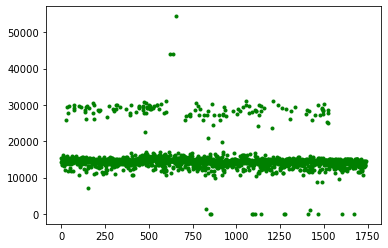

In [27]:
plt.plot(wif606w,'g.')
print('-hmm, not sure why there are a few points in the weight image with bizarre weight values (extra high), but clearly this is gonna lead to wi/wmax that are greater than 1')
print('-so, probably need to flag anything with the column >1, for both wib_wimx and wir_wimx')